In [61]:
from langchain_ollama import OllamaLLM
from langchain_ollama import OllamaEmbeddings

# LLM cho chat
llm = OllamaLLM(
    model="gemma3:1b",
    base_url="http://localhost:11434"
)

# Embedding model
embedding = OllamaEmbeddings(
    model="embeddinggemma:300m",
    base_url="http://localhost:11434"
)

# Multi-representation Indexing

In [2]:
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

loader = WebBaseLoader("https://lilianweng.github.io/posts/2024-02-05-human-data-quality/")
docs.extend(loader.load())

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
import uuid

from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

chain = (
    {"doc": lambda x: x.page_content}
    | ChatPromptTemplate.from_template("Summarize the following document:\n\n{doc}")
    | llm
    | StrOutputParser()
)

summaries = chain.batch(docs, {"max_concurrency": 5})

In [4]:
from langchain_core.stores import InMemoryByteStore
from langchain_community.vectorstores import Chroma
from langchain_classic.retrievers import MultiVectorRetriever


# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="summaries",
                     embedding_function=embedding)

# The storage layer for the parent documents
store = InMemoryByteStore()
id_key = "doc_id"

# The retriever
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
)
doc_ids = [str(uuid.uuid4()) for _ in docs]

# Docs linked to summaries
summary_docs = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(summaries)
]

# Add
retriever.vectorstore.add_documents(summary_docs)
retriever.docstore.mset(list(zip(doc_ids, docs)))

C:\Users\xgear\AppData\Local\Temp\ipykernel_30492\3241149309.py:7: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the `langchain-chroma package and should be used instead. To use it run `pip install -U `langchain-chroma` and import as `from `langchain_chroma import Chroma``.
  vectorstore = Chroma(collection_name="summaries",


In [5]:
query = "Memory in agents"
sub_docs = vectorstore.similarity_search(query,k=1)
sub_docs[0]

Document(metadata={'doc_id': '0c7a788e-c7ea-4324-b916-417b8e7515b2'}, page_content='### Challenges in LLM-Centered Agent Systems  \nThe design of LLM-powered agents faces several critical challenges, as highlighted in the provided references and technical discussions:  \n\n---\n\n#### **1. Finite Context Length**  \n- **Issue**: Limited context windows restrict historical information, detailed instructions, and API responses. This impacts long-term planning and adaptive learning.  \n- **Mitigation**:  \n  - **Vector Search**: Tools like **ScaNN** (Google) or **Weaviate** (via vector databases) enable efficient retrieval of large knowledge pools, bypassing the limitations of attention mechanisms.  \n  - **Hybrid Models**: Combining LLMs with external knowledge sources (e.g., databases, tools) via **tool augmentation** (e.g., **TALM**, **ChemCrow**) to expand contextual awareness.  \n\n---\n\n#### **2. Long-Term Planning and Task Decomposition**  \n- **Issue**: LLMs struggle with plannin

In [8]:
retrieved_docs = retriever._get_relevant_documents(query,run_manager=1)
retrieved_docs[0].page_content

'\n\n\n\n\n\nLLM Powered Autonomous Agents | Lil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\n\n\n\n\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nAgent System Overview\n\nComponent One: Planning\n\nTask Decomposition\n\nSelf-Reflection\n\n\nComponent Two: Memory\n\nTypes of Memory\n\nMaximum Inner Product Search (MIPS)\n\n\nComponent Three: Tool Use\n\nCase Studies\n\nScientific Discovery Agent\n\nGenerative Agents Simulation\n\nProof-of-Concept Examples\n\n\nChallenges\n\nCitation\n\nReferences\n\n\n\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The

# RAPTOR

In [62]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [63]:

loader = DirectoryLoader(
    'data', 
    glob="**/*.txt", 
    loader_cls=TextLoader 
)
docs = loader.load()

In [64]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=20,
    length_function=len,
    is_separator_regex=False,
)

In [65]:
docs = text_splitter.split_documents(docs)
texts = [doc.page_content for doc in docs]

In [66]:
import tiktoken

def num_tokens_from_string(string: str) -> int:
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [67]:
counts = [num_tokens_from_string(t) for t in texts]

<function matplotlib.pyplot.show(close=None, block=None)>

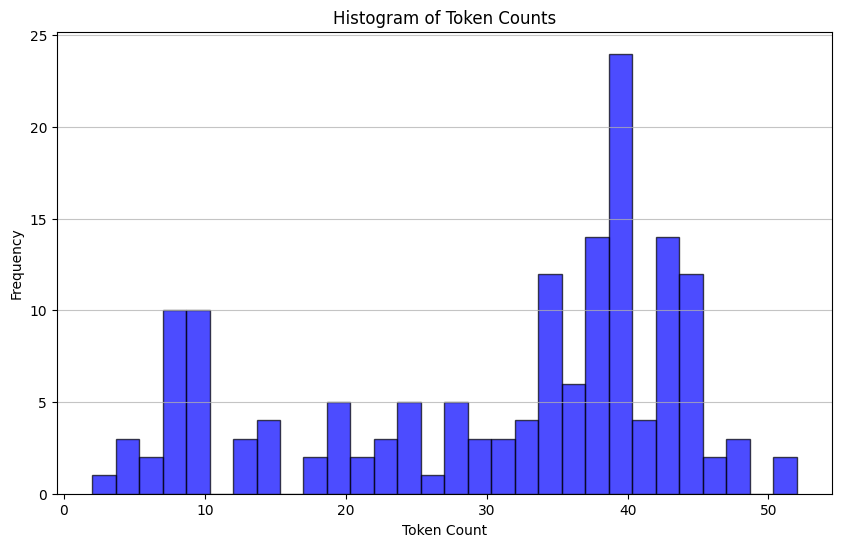

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show

In [69]:
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content)
)

Num tokens in all context: 5265


In [70]:
global_embeddings = [embedding.embed_query(txt) for txt in texts]

In [71]:
global_embeddings[0]

[-0.0875958,
 -0.014998583,
 -0.023134748,
 0.00809763,
 0.021986615,
 -0.0110442415,
 -0.065989524,
 0.036957353,
 0.015390532,
 0.0017792964,
 -0.021313395,
 -0.024743222,
 -0.044343304,
 -0.012609748,
 0.021403423,
 0.012355586,
 -0.039723713,
 -0.0005073741,
 -0.029711602,
 -0.03463323,
 -0.031940807,
 -0.039666574,
 -0.019339602,
 -0.0028010516,
 0.052488696,
 -0.004199381,
 0.07882773,
 -0.009985445,
 -0.0027755355,
 0.05527299,
 0.008487917,
 -0.0062151332,
 0.05898775,
 -0.08441611,
 -0.016722249,
 -0.08200877,
 0.011442107,
 -0.012332296,
 0.03597814,
 -0.015101949,
 0.0041439137,
 0.05272406,
 0.01264288,
 -0.023732722,
 0.010861566,
 0.056008387,
 0.05155042,
 -0.036644578,
 0.01592836,
 0.044800095,
 0.025214229,
 0.03170438,
 0.0030623078,
 -0.07919285,
 -0.021376682,
 -0.017252104,
 -0.032610323,
 0.021022271,
 -0.02001164,
 0.04045185,
 -0.05607485,
 -0.015774172,
 0.00060723873,
 0.014480503,
 0.034341272,
 -0.05919792,
 -0.043153718,
 -0.0054056384,
 -0.010333712,
 0.1

In [72]:
import numpy as np
from typing import Optional
from sklearn.decomposition import PCA # Thay thế UMAP

def reduce_cluster_embeddings_pca(
    embeddings: np.ndarray,
    dim: int,
    # PCA không dùng n_neighbors và metric
) -> np.ndarray:
    return PCA(n_components=dim, random_state=42).fit_transform(embeddings)

dim = 2
pca_results = reduce_cluster_embeddings_pca(global_embeddings, dim)

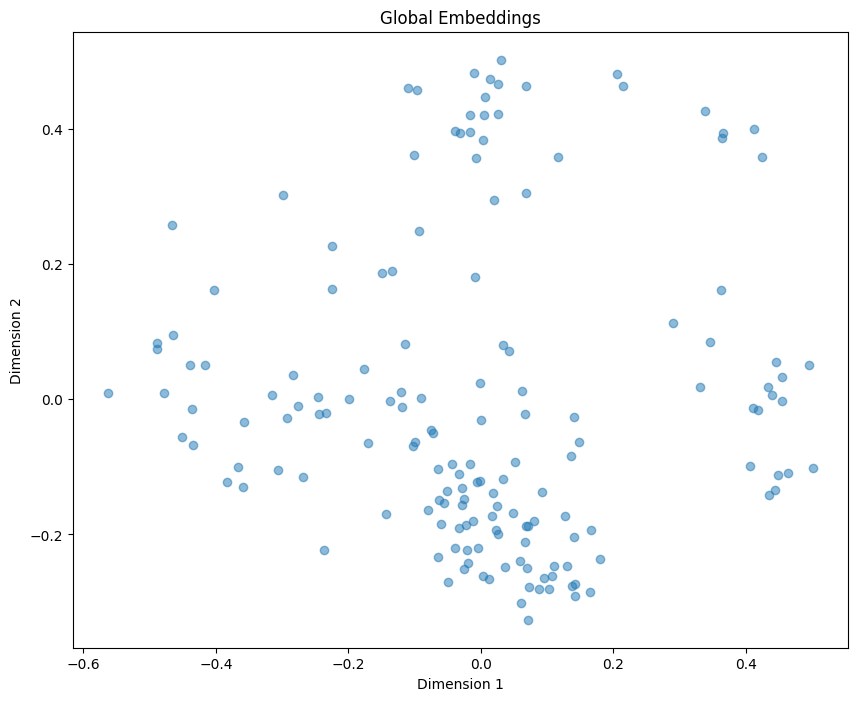

In [73]:
plt.figure(figsize=(10, 8))
plt.scatter(pca_results[:, 0], pca_results[:, 1], alpha=0.5) 
plt.title("Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [74]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

def get_optimal_clusters(embeddings: np.ndarray, max_clusters: int = 50, random_state: int = 1234):
    max_clusters = min(max_clusters, len(embeddings))
    bics = [GaussianMixture(n_components=n, random_state=random_state).fit(embeddings).bic(embeddings)
            for n in range(1, max_clusters)]
    return np.argmin(bics) + 1

def gmm_clustering(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state).fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters

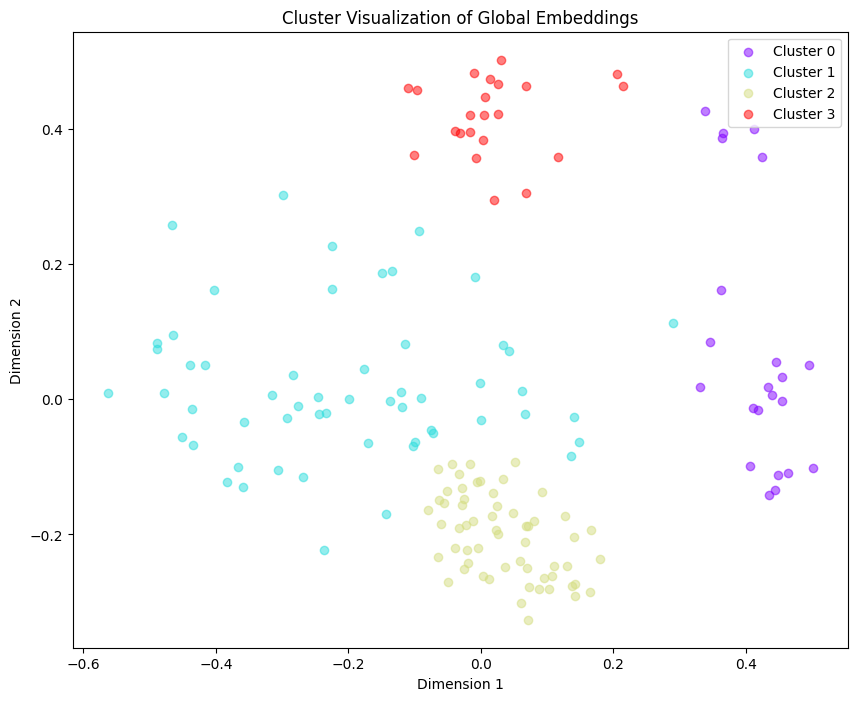

In [75]:
labels, _ = gmm_clustering(pca_results, threshold=0.5)

plot_labels = np.array([label[0] if len(label) > 0 else -1 for label in labels])
plt.figure(figsize=(10, 8))

unique_labels = np.unique(plot_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    mask = plot_labels == label
    plt.scatter(pca_results[mask, 0], pca_results[mask, 1], color=color, label=f'Cluster {label}', alpha=0.5)

plt.title("Cluster Visualization of Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()

In [76]:
import pandas as pd

simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

df = pd.DataFrame({
    'Text': texts,
    'Embedding': list(pca_results),
    'Cluster': simple_labels
})
print(df.head(3))

                                                Text  \
0  Step into our Tuscan-inspired sanctuary, where...   
1  Tuscany, renowned for its breathtaking country...   
2  Begin your journey with an antipasto platter a...   

                                      Embedding  Cluster  
0     [0.09167403387718996, -0.136537208761882]        2  
1  [0.048959706884843815, -0.16868944320270615]        2  
2   [0.07970787032479082, -0.18022114734594127]        2  


In [77]:
def format_cluster_texts(df):
    clustered_texts = {}
    for cluster in df['Cluster'].unique():
        cluster_texts = df[df['Cluster'] == cluster]['Text'].tolist()
        clustered_texts[cluster] = " --- ".join(cluster_texts)
    return clustered_texts

In [78]:
clustered_texts = format_cluster_texts(df)

In [79]:
clustered_texts

{np.int64(2): 'Step into our Tuscan-inspired sanctuary, where the golden hues of sun-kissed landscapes and the earthy aromas of olive groves and vineyards set the stage for a memorable dining experience. Tuscany, --- Tuscany, renowned for its breathtaking countryside and rich culinary heritage, offers a bounty of flavors and traditions to explore. --- Begin your journey with an antipasto platter adorned with cured meats, aged cheeses, and marinated vegetables, reminiscent of leisurely gatherings under the Tuscan sun. Each bite tells a story of --- Indulge in classics like Ribollita, a hearty vegetable soup enriched with cannellini beans and Tuscan kale. This comforting dish, born out of frugality and resourcefulness, warms both body and soul, --- both body and soul, offering a taste of Tuscan tradition with every spoonful. --- Alternatively, savor the simplicity of Cacciucco, a rustic seafood stew brimming with the bounty of the Mediterranean. With its roots firmly planted in coastal c

In [80]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

template = """You are an assistant to create a detailed summary of the text input prodived.
Text:
{text}
"""
prompt = ChatPromptTemplate.from_template(template)
chain = prompt | llm | StrOutputParser()

In [81]:
summaries = {}
for cluster, text in clustered_texts.items():
    summary = chain.invoke({"text": text})
    summaries[cluster] = summary

In [82]:
summaries

{np.int64(2): 'Okay, here\'s a detailed summary of the text provided, broken down into key sections and organized for clarity.\n\n**Overall Summary:**\n\nThe text is a descriptive and evocative prologue to a multi-course dining experience, centered around a journey through Italy. It\'s a warm and inviting introduction, emphasizing the region\'s history, culture, and culinary traditions. It meticulously outlines a menu of dishes inspired by various Italian regions, each with a distinct flavor profile and historical context.  The tone is enthusiastic and focuses on the sensory experience – the aromas, tastes, and textures of the food and environment.\n\n**Detailed Breakdown by Section:**\n\n1.  **Introduction & Setting the Scene:**\n    *   The text establishes the location as Tuscany, with its focus on landscapes and rich culinary heritage.\n    *   It immediately establishes a feeling of leisurely enjoyment and appreciation for traditional food.\n    *   It uses evocative language like

In [83]:
embedded_summaries = [embedding.embed_query(summary) for summary in summaries.values()]

embedded_summaries_np = np.array(embedded_summaries)

labels, _ = gmm_clustering(embedded_summaries_np, threshold=0.5)

simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

In [84]:
clustered_summaries = {}
for i, label in enumerate(simple_labels):
    if label not in clustered_summaries:
        clustered_summaries[label] = []
    clustered_summaries[label].append(list(summaries.values())[i])

In [85]:
clustered_summaries

{np.int64(0): ['Okay, here\'s a detailed summary of the text provided, broken down into key sections and organized for clarity.\n\n**Overall Summary:**\n\nThe text is a descriptive and evocative prologue to a multi-course dining experience, centered around a journey through Italy. It\'s a warm and inviting introduction, emphasizing the region\'s history, culture, and culinary traditions. It meticulously outlines a menu of dishes inspired by various Italian regions, each with a distinct flavor profile and historical context.  The tone is enthusiastic and focuses on the sensory experience – the aromas, tastes, and textures of the food and environment.\n\n**Detailed Breakdown by Section:**\n\n1.  **Introduction & Setting the Scene:**\n    *   The text establishes the location as Tuscany, with its focus on landscapes and rich culinary heritage.\n    *   It immediately establishes a feeling of leisurely enjoyment and appreciation for traditional food.\n    *   It uses evocative language lik

In [86]:
final_summaries = {}
for cluster, texts in clustered_summaries.items():
    combined_text = ' '.join(texts)
    summary = chain.invoke({"text": combined_text})
    final_summaries[cluster] = summary

In [87]:
final_summaries

{np.int64(0): "Okay, let’s expand on the “Legacy & Commitment” section, focusing on the specific ways Giovanni cultivates this legacy. Here’s a revised section incorporating more detail and imagery, aiming for a richer and more evocative feel:\n\n**Legacy & Commitment (Expanded)**\n\nGiovanni’s commitment to preserving his family’s culinary heritage isn’t merely a professional endeavor; it’s a deeply personal and enduring dedication. He views his restaurant, Bella Vista, as a living museum, a tangible embodiment of generations of culinary knowledge and artistic expression.  He doesn’t simply maintain recipes; he weaves them into the very fabric of the restaurant’s ambiance, ensuring that each dish carries a story – a whisper of the land, a memory of the hands that crafted it.\n\nHe actively seeks to mentor young chefs, not just providing instruction, but offering a gentle guiding hand, encouraging them to understand the soul of Italian cooking. He invests heavily in sourcing ingredient

In [88]:
texts_from_df = df['Text'].tolist()
texts_from_clustered_texts = list(clustered_texts.values())
texts_from_final_summaries = list(final_summaries.values())

combined_texts = texts_from_df + texts_from_clustered_texts + texts_from_final_summaries

In [89]:
from langchain_community.vectorstores import Chroma

vectorstore = Chroma.from_texts(texts=combined_texts, embedding=embedding)

In [91]:
def adjust_final_number(string: str, max_threshold: int, initial_number: int) -> int:
    final_number = initial_number
    while final_number < max_threshold:
        retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})
        docs = retriever.invoke(string)
        text = "".join([doc.page_content for doc in docs])
        if num_tokens_from_string(text) < max_threshold:
            final_number += 1
        else:
            break
    return final_number

final_number = adjust_final_number("Who is the owner of the restaurant", 10000, 4)

In [92]:
final_number

158

In [93]:
retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})

In [96]:
from langchain_core.runnables import RunnablePassthrough

template = """
You are a highly constrained, context-based fact extractor. 
Your sole purpose is to answer the question using ONLY the provided context. 
If the information, such as the restaurant owner's name, is present in the context, you MUST provide it.
Do NOT use external knowledge, and do NOT apologize or state you cannot access information.

Context:
{context}

Question: {question}

Extracted Answer:
"""
prompt = ChatPromptTemplate.from_template(template)


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [97]:
rag_chain.invoke("Who is the owner of the restaurant")

'Giovanni'